In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_openai langchain_experimental matplotlib langgraph

In [43]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("TAVILY_API_KEY")

In [61]:
from typing import Annotated, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END, START
from langgraph.types import Command
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

tavily_tool = TavilySearchResults()

def define_system_prompt(suffix: str) -> str:
    return (
        "You are helpful AI assistant, collaborating with other AI assistants"
        "Use provided tools to answer and ask follow up questions."
        f"\n{suffix}"
        )


openai_model = ChatOpenAI(api_key=openai_api_key, model="gpt-4o")

def get_next_node(last_message: AIMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

# Chat agent and gather information
chat_agent = create_react_agent(openai_model, tools=[tavily_tool], prompt=define_system_prompt(""
"You can only do HR outreach tasks, should ask follow up questions as needed to identify sequence content, angle, # steps, etc. When "
"the information is enough, you begin to think about sequence, number of steps. You will be using that to work with sequence generator agents"""))

# Define the logic in chat_agent
def chat_agent_node(state: MessagesState) -> Command[Literal["sequence_generator", END]]:
    result = chat_agent.invoke(state)
    print(result["messages"][-1].content)
    goto = get_next_node(result["messages"][-1], "sequence_generator")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chat_agent")
    return Command(update={"messages": result["messages"]}, goto=goto)

human_message_1 = HumanMessage(content="""Hey Helix, The role is a software engineer. Write an HR outreach sequence via email. I’d like: 
1. Introduction email 
2. Follow-up after 3 days 
3. Final email before the interview schedule. The project is AI-powered e-learning, and the potential candidate is the goal.""")
state = MessagesState(human_message)
chat_agent_node(state)

human_message_2 = HumanMessage(content="outreach email sequence")
state_2 = MessagesState(human_message_2)
chat_agent_node(state_2)




# Sequence generator agent
sequences_agent = create_react_agent(openai_model, tools=[tavily_tool], 
                                     prompt=define_system_prompt("""
    You can only generate sequences of step with information on it. You are working with chat agent colleague
"""))


def sequence_agent_node(state: MessagesState) -> Command[Literal["chat_agent"]]:
    result = sequences_agent.invoke(state)
    print(result["messages"][-1].content)
    goto = get_next_node(result["messages"][-1], "chat_agent")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="sequence_generator")
    return Command(update={"messages": result["messages"]}, goto=goto)





I can assist with HR outreach tasks by helping you design email sequences, follow-up strategies, or outreach campaigns. Please provide more details on what kind of task you need assistance with. For instance, are you looking for an outreach email to candidates, a follow-up sequence after an initial meeting, or perhaps some other kind of communication strategy? Let me know so I can offer more tailored assistance!
Hi, how can I assist you with HR outreach tasks today?


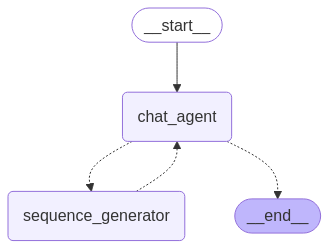

In [59]:
from langgraph.graph import StateGraph, START
from typing import Annotated, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END, START
from langgraph.types import Command
from agents import chat_agent_node, sequence_agent_node
from IPython.display import Image, display



workflow = StateGraph(MessagesState)
workflow.add_node("chat_agent", chat_agent_node)
workflow.add_node("sequence_generator", sequence_agent_node)

workflow.add_edge(START, "chat_agent")
graph = workflow.compile()




try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [46]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Write a HR sequence targetting software enginee talent in SF Cali"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)

for s in events:
    print(s)

TypeError: 'generator' object is not subscriptable